In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg16
import numpy as np
import cv2
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.io
from scipy.ndimage import gaussian_filter
import h5py

In [ ]:
class VGGBackbone(nn.Module):
    def __init__(self):
        super(VGGBackbone, self).__init__()
        vgg = vgg16(pretrained=True)
        self.features = vgg.features[:23]
        
        for param in self.features[:10].parameters():
            param.requires_grad = False
    
    def forward(self, x):
        return self.features(x)

In [ ]:
class MCNNModule(nn.Module):
    def __init__(self, input_channels=512):
        super(MCNNModule, self).__init__()
        
        self.column1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, kernel_size=7, padding=3),
            nn.ReLU(inplace=True)
        )
        
        self.column2 = nn.Sequential(
            nn.Conv2d(input_channels, 20, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 40, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(40, 20, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20, 10, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )
        
        self.column3 = nn.Sequential(
            nn.Conv2d(input_channels, 24, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(24, 48, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(48, 24, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 12, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.fusion = nn.Conv2d(30, 1, kernel_size=1)
    
    def forward(self, x):
        col1 = self.column1(x)
        col2 = self.column2(x)
        col3 = self.column3(x)
        
        fused = torch.cat([col1, col2, col3], dim=1)
        density_map = self.fusion(fused)
        
        return density_map

In [ ]:
class CSRNetModule(nn.Module):
    def __init__(self, input_channels=512):
        super(CSRNetModule, self).__init__()
        
        self.backend = nn.Sequential(
            nn.Conv2d(input_channels, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )
    
    def forward(self, x):
        return self.backend(x)

In [ ]:
class MCNN_CSRNet(nn.Module):
    def __init__(self):
        super(MCNN_CSRNet, self).__init__()
        
        self.vgg_backbone = VGGBackbone()
        self.mcnn_branch = MCNNModule(input_channels=512)
        self.csrnet_branch = CSRNetModule(input_channels=512)
        
        self.fusion_conv = nn.Conv2d(2, 1, kernel_size=1)
        
    def forward(self, x):
        vgg_features = self.vgg_backbone(x)
        
        mcnn_density = self.mcnn_branch(vgg_features)
        csrnet_density = self.csrnet_branch(vgg_features)
        
        if mcnn_density.shape != csrnet_density.shape:
            csrnet_density = F.interpolate(csrnet_density, size=mcnn_density.shape[2:], mode='bilinear', align_corners=False)
        
        combined = torch.cat([mcnn_density, csrnet_density], dim=1)
        final_density = self.fusion_conv(combined)
        
        return final_density

class CrowdDataset(Dataset):
    def __init__(self, img_paths, gt_paths, transform=None, is_training=True):
        self.img_paths = img_paths
        self.gt_paths = gt_paths
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.is_training:
            gt_path = self.gt_paths[idx]
            try:
                img_dimensions = img.size()
            except TypeError:
                img_dimensions = img.size


            density_map = self.load_ground_truth(gt_path, (img_dimensions[1], img_dimensions[0]))
            return img, torch.FloatTensor(density_map).unsqueeze(0)
        else:
            return img, img_path

    def load_ground_truth(self, gt_path, img_shape):
        density_map = np.zeros(img_shape)

        if gt_path and os.path.exists(gt_path):
            try:
                mat_data = scipy.io.loadmat(gt_path)

                points = None
                if 'image_info' in mat_data:
                    try:
                        potential_points = mat_data['image_info'][0,0][0,0][0]

                        if isinstance(potential_points, np.ndarray) and potential_points.ndim == 2 and potential_points.shape[1] == 2:
                            points = potential_points
                        else:
                            print(f"Debugging {gt_path}: Data found at 'image_info'[0,0][0,0][0] but not (N, 2) array (Type: {type(potential_points)}, Shape: {potential_points.shape if isinstance(potential_points, np.ndarray) else 'N/A'}).")


                    except (IndexError, KeyError, TypeError, ValueError, AttributeError) as e:
                        print(f"Debugging {gt_path}: Accessing 'image_info'[0,0][0,0][0] failed: {e}")
                        points = None


                if points is None and 'annPoints' in mat_data:
                    ann_points_data = mat_data.get('annPoints')
                    if ann_points_data is not None and isinstance(ann_points_data, np.ndarray) and ann_points_data.ndim == 2 and ann_points_data.shape[1] == 2:
                        points = ann_points_data
                        print(f"Debugging {gt_path}: Successfully accessed points via annPoints fallback.")
                    else:
                        print(f"Debugging {gt_path}: 'annPoints' field is None or not the expected (N, 2) array format.")
                        points = np.array([])


                if points is None:
                    points = np.array([])
                    print(f"Debugging {gt_path}: Points extraction failed after trying both paths. Initializing empty points.")


                if points.size > 0:
                    if not isinstance(points, np.ndarray) or points.ndim != 2 or points.shape[1] != 2:
                        print(f"Warning {gt_path}: Final points validation failed. Shape: {points.shape if isinstance(points, np.ndarray) else 'N/A'}. Resetting to empty.")
                        points = np.array([])


                if points.size > 0:
                    for point in points:
                        if isinstance(point, np.ndarray) and point.ndim >= 1 and point.shape[0] >= 2:
                            x, y = int(round(point[0])), int(round(point[1]))
                            if 0 <= y < img_shape[0] and 0 <= x < img_shape[1]:
                                density_map[y, x] = 1
                        else:
                            print(f"Warning {gt_path}: Skipping potentially malformed point data: {point}")


                    density_map = gaussian_filter(density_map, sigma=3)

            except Exception as e:
                print(f"Error loading or processing {gt_path}: {e}")
                return np.zeros(img_shape)
        else:
            if self.is_training:
                print(f"Warning: Training GT path missing or does not exist: {gt_path}")
            return np.zeros(img_shape)

        return density_map

In [ ]:
def get_image_paths(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    paths = []
    
    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            paths.append(os.path.join(folder_path, file))
    
    return sorted(paths)

def get_corresponding_gt_paths(img_paths, gt_folder):
    gt_paths = []
    gt_extension = '.mat'

    for img_path in img_paths:
        img_name_base = os.path.splitext(os.path.basename(img_path))[0]

        gt_path = None

        potential_path_standard = os.path.join(gt_folder, img_name_base + gt_extension)
        if os.path.exists(potential_path_standard):
            gt_path = potential_path_standard
        else:
            potential_path_gt_prefix = os.path.join(gt_folder, 'GT_' + img_name_base + gt_extension)
            if os.path.exists(potential_path_gt_prefix):
                gt_path = potential_path_gt_prefix
            else:
                for suffix in ['_gt', '_GT', '_density']:
                    potential_path_suffix = os.path.join(gt_folder, img_name_base + suffix + gt_extension)
                    if os.path.exists(potential_path_suffix):
                        gt_path = potential_path_suffix
                        break


        gt_paths.append(gt_path)

    return gt_paths

class CrowdCounter:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        super().__init__()
        self.device = device
        self.model = MCNN_CSRNet().to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-5, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.5)

        input_size = (512, 512)
        self.train_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        self.input_size = input_size


    def prepare_data(self, train_img_folder, train_gt_folder, test_img_folder, test_gt_folder):
        train_img_paths_all = get_image_paths(train_img_folder)
        test_img_paths_all = get_image_paths(test_img_folder)

        train_gt_paths_all = get_corresponding_gt_paths(train_img_paths_all, train_gt_folder)
        test_gt_paths_all = get_corresponding_gt_paths(test_img_paths_all, test_gt_folder)

        train_img_paths = [img_path for img_path, gt_path in zip(train_img_paths_all, train_gt_paths_all) if gt_path is not None]
        train_gt_paths = [gt_path for gt_path in train_gt_paths_all if gt_path is not None]

        test_img_paths = test_img_paths_all
        test_gt_paths = test_gt_paths_all

        train_count = len(train_img_paths)
        test_count = len(test_img_paths)

        print(f"Found {len(train_img_paths_all)} initial training images, {train_count} with valid GT.")
        print(f"Found {len(test_img_paths_all)} initial test images, {sum(1 for p in test_gt_paths if p is not None)} with valid GT.")

        self.train_dataset = CrowdDataset(train_img_paths, train_gt_paths,
                                          transform=self.train_transform, is_training=True)
        self.test_dataset = CrowdDataset(test_img_paths, [None] * len(test_img_paths),
                                         transform=self.test_transform, is_training=False)

        if train_count == 0:
            print("No training images found with valid GT. Skipping DataLoader creation for training.")
            self.train_loader = None
        else:
            self.train_loader = DataLoader(self.train_dataset, batch_size=4, shuffle=True, num_workers=0)

        self.test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False, num_workers=0)


        self.test_gt_paths = test_gt_paths_all

        return train_count, test_count

    def train(self, num_epochs=100, save_path='crowd_counter_model.pth'):
        print(f"Training on {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        best_loss = float('inf')
        train_losses = []

        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0
            num_batches = 0

            for batch_idx, (images, density_maps) in enumerate(self.train_loader):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device)

                self.optimizer.zero_grad()

                predictions = self.model(images)

                if predictions.shape[2:] != density_maps.shape[2:]:
                    predictions = F.interpolate(predictions, size=density_maps.shape[2:],
                                                mode='bilinear', align_corners=False)


                loss = self.criterion(predictions, density_maps)

                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

                if batch_idx % 10 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(self.train_loader)}, '
                          f'Loss: {loss.item():.6f}')

            avg_loss = epoch_loss / num_batches
            train_losses.append(avg_loss)

            print(f'Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.6f}')

            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(self.model.state_dict(), save_path)
                print(f'Best model saved with loss: {best_loss:.6f}')

            self.scheduler.step()

            current_lr = self.optimizer.param_groups[0]['lr']
            print(f'Learning rate: {current_lr:.8f}')
            print('-' * 50)

        plt.figure(figsize=(10, 6))
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.savefig('training_loss.png')
        plt.show()

        print("Training completed!")

    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"Model loaded from {model_path}")

    def test(self):
        self.model.eval()
        predictions = []
        ground_truths = []

        print("Testing model...")

        with torch.no_grad():
            for idx, (image, img_path) in enumerate(self.test_loader):
                image = image.to(self.device)

                pred_density = self.model(image)
                pred_count = torch.sum(pred_density).cpu().numpy()
                predictions.append(pred_count)

                gt_path = self.test_gt_paths[idx]
                if gt_path and os.path.exists(gt_path):
                    gt_count = self.get_ground_truth_count(gt_path)
                    ground_truths.append(gt_count)
                else:
                    ground_truths.append(0)

                print(f"Image {idx+1} ({os.path.basename(self.test_dataset.img_paths[idx])}): Predicted={pred_count:.2f}, Actual={ground_truths[-1]}")


        if len(ground_truths) != len(predictions):
            print("Warning: Length of ground truths and predictions do not match!")
            min_len = min(len(ground_truths), len(predictions))
            ground_truths = ground_truths[:min_len]
            predictions = predictions[:min_len]


        mae = mean_absolute_error(ground_truths, predictions)
        mse = mean_squared_error(ground_truths, predictions)
        rmse = np.sqrt(mse)

        accurate_predictions = sum(
            1 for p, g in zip(predictions, ground_truths)
            if (g > 0 and abs(p - g) <= 0.1 * g) or (g == 0 and abs(p) <= 1)
        )

        accuracy = accurate_predictions / len(predictions) * 100 if len(predictions) > 0 else 0

        print("\n" + "="*50)
        print("EVALUATION RESULTS:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"Accuracy (±10%): {accuracy:.2f}%")
        print("="*50)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        ground_truths_np = np.array(ground_truths)
        predictions_np = np.array(predictions)
        plt.scatter(ground_truths_np, predictions_np, alpha=0.6)
        if len(ground_truths_np) > 0:
            plot_min = min(np.min(ground_truths_np), np.min(predictions_np))
            plot_max = max(np.max(ground_truths_np), np.max(predictions_np))
            plt.plot([plot_min, plot_max],
                     [plot_min, plot_max], 'r--')
        plt.xlabel('Ground Truth Count')
        plt.ylabel('Predicted Count')
        plt.title('Predicted vs Ground Truth')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        errors = [abs(p - g) for p, g in zip(predictions, ground_truths)]
        if errors:
            plt.hist(errors, bins=20)
        plt.xlabel('Absolute Error')
        plt.ylabel('Frequency')
        plt.title('Error Distribution')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('evaluation_results.png')
        plt.show()

        return {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'Accuracy': accuracy,
            'predictions': predictions,
            'ground_truths': ground_truths
        }


    def get_ground_truth_count(self, gt_path):
        try:
            if gt_path is None or not os.path.exists(gt_path):
                return 0

            mat = scipy.io.loadmat(gt_path)
            points = mat.get('image_info', [{}])[0].get('location', [])
            if len(points) == 0:
                points = mat.get('annPoints', [])

            if isinstance(points, (list, np.ndarray)):
                return len(points)
            else:
                return 0

        except Exception as e:
            print(f"Error reading {gt_path}: {e}")
            return 0

Preparing datasets...
Found 400 initial training images, 400 with valid GT.
Found 316 initial test images, 316 with valid GT.

Starting training...
Training on cuda
Model parameters: 17,861,081
Epoch 1/100, Batch 1/100, Loss: 0.375054
Epoch 1/100, Batch 11/100, Loss: 0.211701
Epoch 1/100, Batch 21/100, Loss: 0.070259
Epoch 1/100, Batch 31/100, Loss: 0.034937
Epoch 1/100, Batch 41/100, Loss: 0.031740
Epoch 1/100, Batch 51/100, Loss: 0.027838
Epoch 1/100, Batch 61/100, Loss: 0.016074
Epoch 1/100, Batch 71/100, Loss: 0.013750
Epoch 1/100, Batch 81/100, Loss: 0.010664
Epoch 1/100, Batch 91/100, Loss: 0.008021
Epoch 1/100 completed. Average Loss: 0.062891
Best model saved with loss: 0.062891
Learning rate: 0.00001000
--------------------------------------------------
Epoch 2/100, Batch 1/100, Loss: 0.005656
Epoch 2/100, Batch 11/100, Loss: 0.004103
Epoch 2/100, Batch 21/100, Loss: 0.002381
Epoch 2/100, Batch 31/100, Loss: 0.002621
Epoch 2/100, Batch 41/100, Loss: 0.002228
Epoch 2/100, Batch

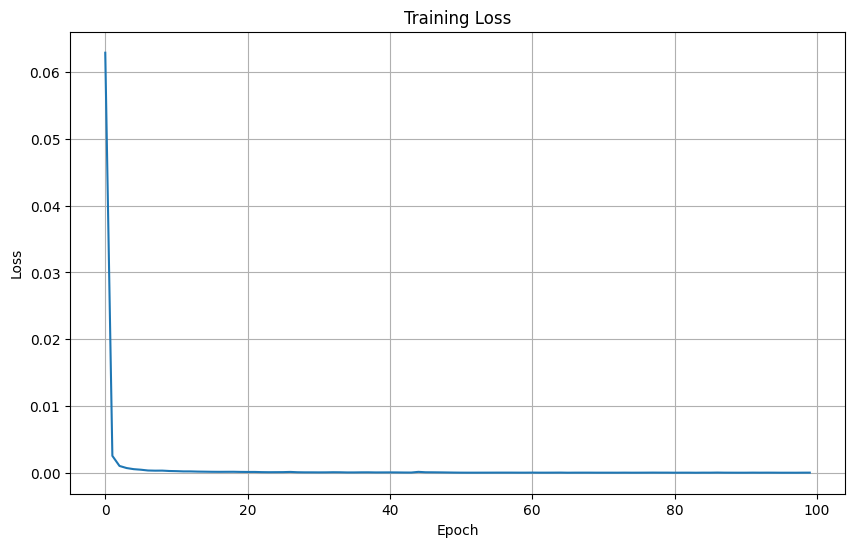

Training completed!

Starting evaluation...
Testing model...
Error reading crowd_wala_dataset\test_data\ground_truth\GT_IMG_1.mat: 'numpy.ndarray' object has no attribute 'get'
Image 1 (IMG_1.jpg): Predicted=-8.02, Actual=0
Error reading crowd_wala_dataset\test_data\ground_truth\GT_IMG_10.mat: 'numpy.ndarray' object has no attribute 'get'
Image 2 (IMG_10.jpg): Predicted=-7.45, Actual=0
Error reading crowd_wala_dataset\test_data\ground_truth\GT_IMG_100.mat: 'numpy.ndarray' object has no attribute 'get'
Image 3 (IMG_100.jpg): Predicted=-8.76, Actual=0
Error reading crowd_wala_dataset\test_data\ground_truth\GT_IMG_101.mat: 'numpy.ndarray' object has no attribute 'get'
Image 4 (IMG_101.jpg): Predicted=-7.29, Actual=0
Error reading crowd_wala_dataset\test_data\ground_truth\GT_IMG_102.mat: 'numpy.ndarray' object has no attribute 'get'
Image 5 (IMG_102.jpg): Predicted=-9.30, Actual=0
Error reading crowd_wala_dataset\test_data\ground_truth\GT_IMG_103.mat: 'numpy.ndarray' object has no attribut

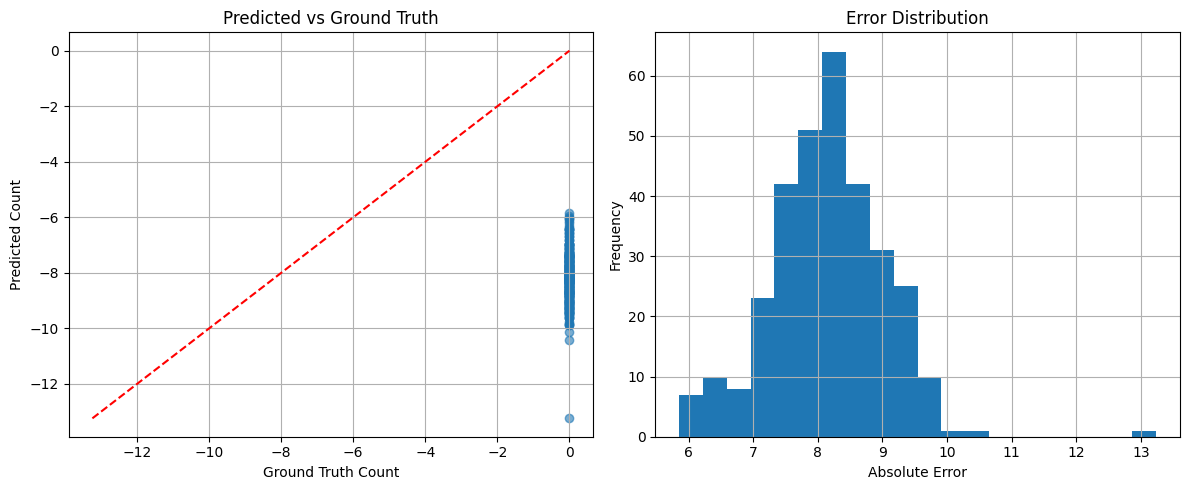

TypeError: Object of type ndarray is not JSON serializable

In [ ]:
def main():
    """Main function to run the crowd counting pipeline"""

    counter = CrowdCounter()

    train_img_folder = "crowd_wala_dataset\\train_data\\images"
    train_gt_folder = "crowd_wala_dataset\\train_data\\ground_truth"
    test_img_folder = "crowd_wala_dataset\\test_data\\images"
    test_gt_folder = "crowd_wala_dataset\\test_data\\ground_truth"

    print("Preparing datasets...")
    train_count, test_count = counter.prepare_data(
        train_img_folder, train_gt_folder,
        test_img_folder, test_gt_folder
    )

    if counter.train_loader is None or len(counter.train_dataset) == 0:
        print("No training data loaded. Skipping training.")
    else:
        print("\nStarting training...")
        counter.train(num_epochs=100, save_path='mcnn_csrnet_model.pth')

    if counter.test_loader is None or len(counter.test_dataset) == 0:
        print("No test data loaded. Skipping evaluation.")
    else:
        print("\nStarting evaluation...")
        results = counter.test()

        with open('evaluation_results.json', 'w') as f:
            serializable_results = {k: (v.tolist() if isinstance(v, (np.ndarray, torch.Tensor)) else v)
                                    for k, v in results.items()}
            json.dump(serializable_results, f, indent=2)

        print("\nResults saved to 'evaluation_results.json'")


def inference_example():
    """Example of how to use the trained model for inference"""

    counter = CrowdCounter()

    model_path = 'mcnn_csrnet_model.pth'
    if os.path.exists(model_path):
        counter.load_model(model_path)
    else:
        print(f"Model file not found at {model_path}. Skipping inference example.")
        return

    img_path = "crowd_wala_dataset\\test_data\\images\\IMG_2.jpg"

    if not os.path.exists(img_path):
        print(f"Image file not found at {img_path}. Skipping inference example.")
        return


    img = Image.open(img_path).convert('RGB')
    img_tensor = counter.test_transform(img).unsqueeze(0).to(counter.device)

    counter.model.eval()
    with torch.no_grad():
        pred_density = counter.model(img_tensor)
        pred_count = torch.sum(pred_density).cpu().numpy()

    print(f"Predicted count for {img_path}: {pred_count:.2f}")

    return pred_count

if __name__ == "__main__":
    main()

In [ ]:
def inference_example():
    """Example of how to use the trained model for inference"""

    counter = CrowdCounter()

    model_path = 'mcnn_csrnet_model.pth'
    if os.path.exists(model_path):
        counter.load_model(model_path)
    else:
        print(f"Model file not found at {model_path}. Skipping inference example.")
        return

    img_path = "crowd_wala_dataset\\test_data\\images\\IMG_48.jpg"

    if not os.path.exists(img_path):
        print(f"Image file not found at {img_path}. Skipping inference example.")
        return


    img = Image.open(img_path).convert('RGB')
    img_tensor = counter.test_transform(img).unsqueeze(0).to(counter.device)

    counter.model.eval()
    with torch.no_grad():
        pred_density = counter.model(img_tensor)
        pred_count = torch.sum(pred_density).cpu().numpy()

    print(f"Predicted count for {img_path}: {pred_count:.2f}")

    return pred_count
inference_example()

Model loaded from mcnn_csrnet_model.pth
Predicted count for crowd_wala_dataset\test_data\images\IMG_48.jpg: -8.37


array(-8.374216, dtype=float32)